In [3]:
import cv2 
print(cv2.__file__)
print(cv2.data.haarcascades)

C:\Users\hp\anaconda3\Lib\site-packages\cv2\__init__.py
C:\Users\hp\anaconda3\Lib\site-packages\cv2\data\


In [1]:
import subprocess
import json
import cv2
import os
import time
import matplotlib.pyplot as plt
import numpy as np

# 1.) Bursting the video into frames

In [2]:
def get_video_fps(input_video):
    ffprobe_path = r'C:\ffmpeg\bin\ffprobe.exe'  # Path to ffprobe executable
    cmd = [
        ffprobe_path,
        '-v', 'error',
        '-select_streams', 'v:0',
        '-show_entries', 'stream=r_frame_rate',
        '-of', 'json',
        input_video
    ]
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode == 0:
        data = json.loads(result.stdout)
        fps_str = data['streams'][0]['r_frame_rate']
        numerator, denominator = map(int, fps_str.split('/'))
        fps = numerator / denominator
        return fps
    else:
        print("Error:", result.stderr)
        return None

def extract_frames(input_video, output_dir, duration=30):
    fps = get_video_fps(input_video)
    if fps is None:
        print("Error: Failed to get video fps.")
        return
    ffmpeg_path = r'C:\ffmpeg\bin\ffmpeg.exe'  # Path to ffmpeg executable
    cmd = [
        ffmpeg_path,
        '-i', input_video,
        '-ss', '0',
        '-t', str(duration),
        '-vf', f'fps={fps}',
        f'{output_dir}/frame_%04d.png'
    ]
    subprocess.run(cmd)

In [3]:
input_video = './videos/forest_gump.mp4'
output_dir = './frames'
extract_frames(input_video, output_dir)

# 2.) Detecting faces in frames and time taken

The time taken to process each frame of the video to identify faces in it depends upon several factors :- 

- **Image Resolution :** Larger images require more computational resources to process, resulting in longer processing times per face. Resizing the input image to a smaller resolution can reduce processing time.

- **Number of Faces :** Detecting multiple faces requires the detector to search for potential face regions across the entire image, increasing the overall processing time.

- `detectMultiScale` **function :** The parameters used in the `detectMultiScale()` function, such as `scaleFactor`, `minNeighbors`, `minSize`, and `maxSize`, affect the efficiency of face detection. Tuning these parameters can optimize processing time while maintaining accurate detection results.

- **Optimizing Haar Cascade XML :** We can try using a more lightweight cascade classifier for face detection. OpenCV provides several pre-trained Haar cascade classifiers with varying levels of complexity. Some of them at varying levels of complexity are:- 

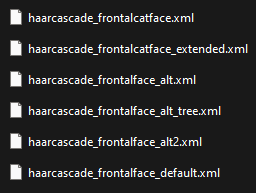





In [5]:
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[0] + box1[2], box2[0] + box2[2])
    y2 = min(box1[1] + box1[3], box2[1] + box2[3])
    
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]

    union_area = box1_area + box2_area - intersection_area
    iou = intersection_area / union_area
    return iou


In [60]:
def get_prev_index(corr, j):
    for i, row in enumerate(corr):
        if row[j] == 1:
            return i
    return -1

def get_correlation_matrix(faces1,faces2):
    n1 = len(faces1)
    n2 = len(faces2)
    corr = np.zeros((n1,n2))
    for i in range(n1):
        for j in range(n2):
            iou = calculate_iou(faces1[i],faces2[j])
            corr[i,j] = 1 if iou>=0.3 else 0
    return corr


def detect_faces_in_frames(frames_dir, output_dir):
    print("entered function")
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    inference_times = []
    prev_faces = np.empty((1,4))
    face_labels = []
    faces = np.empty((1,4))
    
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    break_index = 0
    for filename in sorted(os.listdir(frames_dir)):
        if filename.endswith(".png"):
            
            frame_path = os.path.join(frames_dir, filename)
            frame = cv2.imread(frame_path)
            
            prev_faces = faces

            start_time = time.time()
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
            end_time = time.time()
            inference_time = end_time - start_time
            inference_times.append(inference_time)
            
            temp_label = -np.ones(len(faces))
            
            for i in range(len(faces)):
                for j in range(len(prev_faces)):
                    if calculate_iou(faces[i],prev_faces[j])>=0.5:
                        temp_label[i] = face_labels[j]
                if temp_label[i]==-1:
                    temp_label[i] = 1 if len(face_labels)==0 else np.max(np.array(face_labels)) + 1
                    
            if len(faces)!=0:
                face_labels = temp_label
                        
            print("number of faces in frame ",break_index," : ",len(faces))
            
            for i in range(len(faces)):
                x,y,w,h = faces[i]
                label = face_labels[i]
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                cv2.putText(frame,str(label), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255),3)
                
            if len(faces)!=0:
                prev_faces = faces

            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, frame)
        break_index = break_index + 1

    return inference_times


In [55]:
frames_dir = './frames'
output_dir = './face_detected_frames'
inference_times = detect_faces_in_frames(frames_dir, output_dir)
# print("Inference times for each frame:", inference_times)


entered function
number of faces in frame  0  :  1
number of faces in frame  1  :  1
number of faces in frame  2  :  1
number of faces in frame  3  :  1
number of faces in frame  4  :  1
number of faces in frame  5  :  0
number of faces in frame  6  :  1
number of faces in frame  7  :  1
number of faces in frame  8  :  2
number of faces in frame  9  :  1
number of faces in frame  10  :  1
number of faces in frame  11  :  1
number of faces in frame  12  :  1
number of faces in frame  13  :  2
number of faces in frame  14  :  1
number of faces in frame  15  :  2
number of faces in frame  16  :  2
number of faces in frame  17  :  1
number of faces in frame  18  :  1
number of faces in frame  19  :  1
number of faces in frame  20  :  1
number of faces in frame  21  :  1
number of faces in frame  22  :  1
number of faces in frame  23  :  1
number of faces in frame  24  :  1
number of faces in frame  25  :  2
number of faces in frame  26  :  1
number of faces in frame  27  :  2
number of fac

number of faces in frame  233  :  0
number of faces in frame  234  :  0
number of faces in frame  235  :  0
number of faces in frame  236  :  1
number of faces in frame  237  :  1
number of faces in frame  238  :  0
number of faces in frame  239  :  1
number of faces in frame  240  :  1
number of faces in frame  241  :  1
number of faces in frame  242  :  2
number of faces in frame  243  :  0
number of faces in frame  244  :  1
number of faces in frame  245  :  2
number of faces in frame  246  :  2
number of faces in frame  247  :  1
number of faces in frame  248  :  3
number of faces in frame  249  :  2
number of faces in frame  250  :  2
number of faces in frame  251  :  2
number of faces in frame  252  :  2
number of faces in frame  253  :  2
number of faces in frame  254  :  2
number of faces in frame  255  :  2
number of faces in frame  256  :  3
number of faces in frame  257  :  3
number of faces in frame  258  :  2
number of faces in frame  259  :  2
number of faces in frame  26

number of faces in frame  462  :  0
number of faces in frame  463  :  0
number of faces in frame  464  :  0
number of faces in frame  465  :  0
number of faces in frame  466  :  0
number of faces in frame  467  :  0
number of faces in frame  468  :  0
number of faces in frame  469  :  0
number of faces in frame  470  :  0
number of faces in frame  471  :  0
number of faces in frame  472  :  0
number of faces in frame  473  :  0
number of faces in frame  474  :  0
number of faces in frame  475  :  0
number of faces in frame  476  :  0
number of faces in frame  477  :  0
number of faces in frame  478  :  0
number of faces in frame  479  :  0
number of faces in frame  480  :  0
number of faces in frame  481  :  0
number of faces in frame  482  :  0
number of faces in frame  483  :  0
number of faces in frame  484  :  0
number of faces in frame  485  :  0
number of faces in frame  486  :  0
number of faces in frame  487  :  0
number of faces in frame  488  :  0
number of faces in frame  48

number of faces in frame  691  :  0
number of faces in frame  692  :  0
number of faces in frame  693  :  0
number of faces in frame  694  :  0
number of faces in frame  695  :  0
number of faces in frame  696  :  0
number of faces in frame  697  :  0
number of faces in frame  698  :  1
number of faces in frame  699  :  0
number of faces in frame  700  :  0
number of faces in frame  701  :  1
number of faces in frame  702  :  1
number of faces in frame  703  :  1
number of faces in frame  704  :  1
number of faces in frame  705  :  1
number of faces in frame  706  :  2
number of faces in frame  707  :  1
number of faces in frame  708  :  0
number of faces in frame  709  :  0
number of faces in frame  710  :  0
number of faces in frame  711  :  0
number of faces in frame  712  :  0
number of faces in frame  713  :  0
number of faces in frame  714  :  0
number of faces in frame  715  :  0
number of faces in frame  716  :  0
number of faces in frame  717  :  1
number of faces in frame  71

# 2.2) Time taken to process each frame

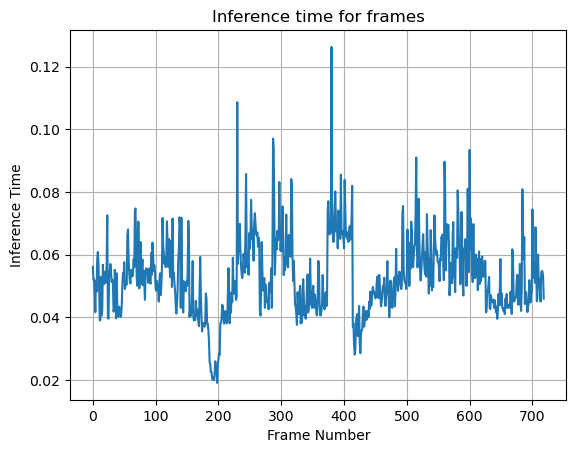

Average Inference time :  0.053  seconds


In [56]:
plt.plot(inference_times)
plt.grid()
plt.title("Inference time for frames")
plt.xlabel("Frame Number")
plt.ylabel("Inference Time")
plt.show()

avg_time = np.mean(np.array(inference_times))
print("Average Inference time : ",np.round(avg_time,3), ' seconds')

---

### For face detection

Link to the video : https://drive.google.com/file/d/1Z2XeBbJYIf9hgOCHp384XfxTykB3jxF5/view?usp=sharing

---

## 3.) Observations based on video

- **Rotated faces :** The detector works only for upright faces and fails to perform on upside-down faces or rotated faces. This is seen in `0:07` timestep of the video. This can be due to the model being trained to identify only upright faces. The cascade filters used in the detector might be just for upright faces.


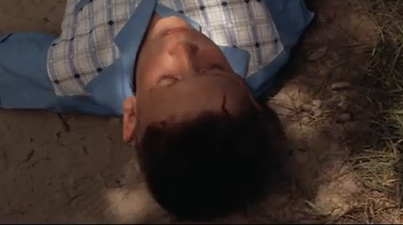


- **Side profile :** The detector often fails to detect faces when the person is showing side-profile of the face rather than looking in the direction of the camera. Such instances are seen in many frames. Timestep `00:01` being an example. Again, this anamoly can be explained based on the cascade filters used for face-detection. The filters are only for upright, forward looking faces, and thus the detector does not account for side looking faces.


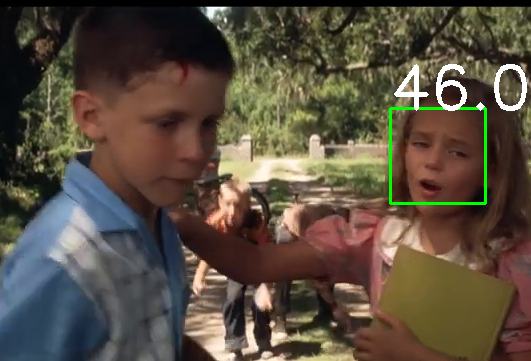


- **partially occuluded :** In some frames, the face gets partially occuluded by objects, causing the detector to fail. It is pretty difficult for any model in general to detect occuluded objects. However, in our case, the low resoultion of the occuluded face makes it even more difficult for the detector.

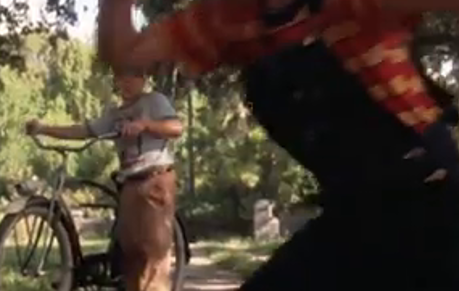


- **non-faces appearing like faces :** In some frames, random objects appear like face, therefore fooling the detector to classify them as faces too. Since the haar-cascades face detector is based on a finite number of filters that determine if a face is detected or not, it can be common to see objects that comply with the filters without being a face at all. 


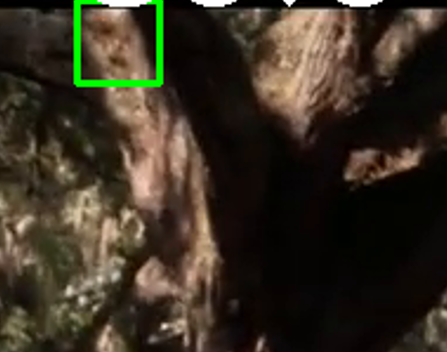


- **Low resolution faces :** In some frames, faces appear in very low resolution and blurred majorly due to motion blur. The detector fails to detect faces in these cases. Blurred patches tend to lose face-features, on which the haar-cascades are based. Therefore, low-resolution faces are not-detected. 


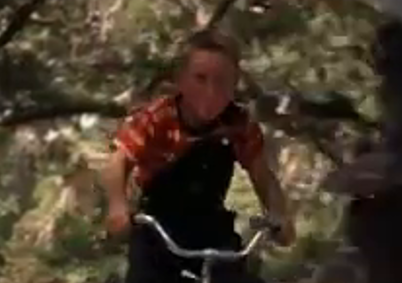


- **Exceptional Cases :** In some very rare cases, the detector fails to detect faces even when nothing is wrong with the face.


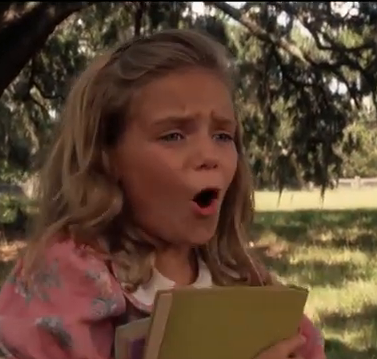

In [59]:
def stitch_frames_to_video(frames_dir, output_video, frame_rate, duration):
    ffmpeg_path = r'C:\ffmpeg\bin\ffmpeg.exe'  # Path to ffmpeg executable
    input_pattern = os.path.join(frames_dir, 'frame_%04d.png')
    cmd = [
        ffmpeg_path,
        '-framerate', str(frame_rate),
        '-i', input_pattern,
        '-c:v', 'libx264',
        '-pix_fmt', 'yuv420p',
        '-t', str(duration),
        output_video
    ]
    subprocess.run(cmd)

# Example usage:
frames_dir = './face_detected_frames'
output_video = './output_video1.mp4'
frame_rate = get_video_fps(input_video) 
duration = 30
stitch_frames_to_video(frames_dir, output_video, frame_rate, duration)


# 4.) Face tracking observations

### Number of unique tracks
Observing the face detected frames, the last frame having a face detected has a track of 95. Therefore a total of 95 unique tracks were created in the first 30 seconds.

### Quality of tracks
The overall quality of the tracks created is directly correlated to the quality of face-detection in between frames. The detectior often loses faces in between frames, leading to start of a new track for the same person. Also, unnessary 1-length tracks are often started due to the algorithm detecting non-face objects as faces. This leads to a large number of tracks in the end. 

- **Do different people get associated in one track?**
No, everytime a new person appears, a different track is started. Exceptions occur when the IoU of the 2 people's faces become greater than 0.5. Then the algorithm might assign same track to both the faces. Failure : frame 249-250

- **Is a unique character associated with one unique track id?**
Yes, the algorithm takes care that a unique id is assigned everytime a new face appears and keeps the id intact with the face unless IoU score between 2 consecutive frames does not drop below 0.5. 

### For face detection + tracking

Link to the video : https://drive.google.com/file/d/1VDU-Rj7tPMvcD2gKxlld1aZUNlp2UEb4/view?usp=sharing

